In [1]:
using CSV, DataFrames, PyPlot, Printf, Statistics, LaTeXStrings, ScikitLearn

PyPlot.matplotlib.style.use("ggplot")

ENV["COLUMNS"] = 500 # display more columns of the DataFrame in the notebook

500

## air pollution data in Beijing, China
source: [here](https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data)

The `missing` values in this `.csv` are denoted by the string `"NA"`. We tell this to `CSV.jl` so that these values can be read in as `missing`.

In [2]:
df = CSV.read("PRSA_Data_Dingling_20130301-20170228.csv", copycols=true, missingstring="NA")
first(df, 5)

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
,Int64,Int64,Int64,Int64,Int64,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,String⍰,Float64⍰,String
1,1,2013,3,1,0,4.0,4.0,3.0,missing,200,82.0,-2.3,1020.8,-19.7,0.0,E,0.5,Dingling
2,2,2013,3,1,1,7.0,7.0,3.0,missing,200,80.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Dingling
3,3,2013,3,1,2,5.0,5.0,3.0,2.0,200,79.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Dingling
4,4,2013,3,1,3,6.0,6.0,3.0,missing,200,79.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Dingling
5,5,2013,3,1,4,5.0,5.0,3.0,missing,200,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Dingling


we will look at average concentrations of pollutants over days, but this has multiple measurements from each day!

so we can group by day and look at the means, let's define a new columne `:date`.

In [3]:
df[!, :date] = map(row -> @sprintf("%d/%d/%d", row[:month], row[:day], row[:year]), eachrow(df))
first(df, 5)

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,date
,Int64,Int64,Int64,Int64,Int64,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,String⍰,Float64⍰,String,String
1,1,2013,3,1,0,4.0,4.0,3.0,missing,200,82.0,-2.3,1020.8,-19.7,0.0,E,0.5,Dingling,3/1/2013
2,2,2013,3,1,1,7.0,7.0,3.0,missing,200,80.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Dingling,3/1/2013
3,3,2013,3,1,2,5.0,5.0,3.0,2.0,200,79.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Dingling,3/1/2013
4,4,2013,3,1,3,6.0,6.0,3.0,missing,200,79.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Dingling,3/1/2013
5,5,2013,3,1,4,5.0,5.0,3.0,missing,200,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Dingling,3/1/2013


let's drop the rows with missing values

In [4]:
dropmissing!(df)
first(df, 5)

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,date
,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,String,Float64,String,String
1,3,2013,3,1,2,5.0,5.0,3.0,2.0,200,79.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Dingling,3/1/2013
2,6,2013,3,1,5,6.0,6.0,3.0,4.0,200,79.0,-4.5,1022.6,-19.5,0.0,NNW,1.7,Dingling,3/1/2013
3,7,2013,3,1,6,5.0,10.0,3.0,4.0,200,77.0,-4.5,1023.4,-19.5,0.0,NNW,1.8,Dingling,3/1/2013
4,8,2013,3,1,7,5.0,6.0,3.0,2.0,200,80.0,-2.1,1024.6,-20.0,0.0,NW,2.5,Dingling,3/1/2013
5,9,2013,3,1,8,8.0,7.0,3.0,3.0,200,79.0,-0.2,1025.2,-20.5,0.0,NNW,2.8,Dingling,3/1/2013


finally, let's look at the average PM10 and NO$_2$ concentration over each day.

we need to group by `:date` and compute these means ourselves.

In [5]:
df_by_day = by(df, :date, avg_PM10=:PM10 => mean, avg_NO2=:NO2 => mean)
first(df_by_day, 5)
# df_by_day = df_by_day[sample(1:nrow(df_by_day), 500, replace=false), :]

,date,avg_PM10,avg_NO2
,String,Float64,Float64
1,3/1/2013,7.25,2.625
2,3/2/2013,41.7083,56.375
3,3/3/2013,72.5556,43.2778
4,3/4/2013,30.2222,16.5
5,3/5/2013,117.208,58.375


## visualize the relationship between PM10 and NO$_2$ levels

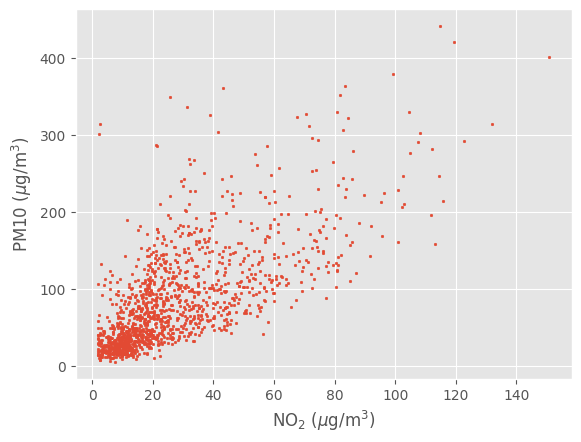

PyObject Text(34.10000000000001, 0.5, 'PM10 ($\\mu$g/m$^3$)')

In [6]:
figure()
scatter(df_by_day[:, :avg_NO2], df_by_day[:, :avg_PM10], s=3)
xlabel(L"NO$_2$ ($\mu$g/m$^3$)")
ylabel(L"PM10 ($\mu$g/m$^3$)")

## a regression problem

we only have an NO$_2$ sensor, but would like to know the PM10 levels because of their harm to human health. We aim to use NO$_2$ measurements to predict the PM10 levels since they are clearly correlated.

let us train a linear model:

$c_{PM10} = \beta c_{NO2} + \beta_0$

and assess its accuracy by an 80/20 train/test split.

determine $\beta, \beta_0$ by minimizing the least squares loss $\ell$ (error on $n$ training data pts):

$\ell(\beta, \beta_0)=\displaystyle \sum_{i=1}^n [c_{PM10, i} -  (\beta c_{NO2, i} + \beta_0)]^2$

In [7]:
@sk_import linear_model : LinearRegression
using ScikitLearn.CrossValidation: train_test_split

#### get data ready for scikitlearn

In [31]:
n_days = nrow(df_by_day)

X = zeros(n_days, 1)
y = zeros(n_days)
for (i, day) in enumerate(eachrow(df_by_day))
    X[i, 1] = day[:avg_NO2]
    y[i] = day[:avg_PM10]
end

#### do 70/30 train/test split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=true)
println("# training data: ",  length(y_train))
println("# test data: ",  length(y_test))

# training data: 978
# test data: 420


#### train linear regressor on the training data

In [33]:
reg = LinearRegression()
reg.fit(X_train, y_train)
println("coeff. β = ", reg.coef_)
println("intercept β₀ = ", reg.intercept_)

coeff. β = [2.107724217570304]
intercept β₀ = 26.610007080112148


#### viz fit to data

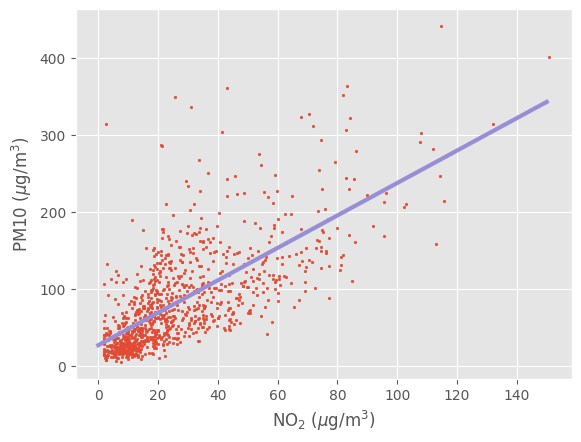

PyObject Text(34.10000000000001, 0.5, 'PM10 ($\\mu$g/m$^3$)')

In [34]:
no2s = range(0.0, stop=150.0, length=150) # since this is linear regression, we can use just two pts...
no2s = reshape(no2s, (150, 1))
pred_pm10s = reg.predict(no2s)

figure()
scatter(X_train[:, 1], y_train, s=3)
plot(no2s, pred_pm10s, color="C2", linewidth=3)
xlabel(L"NO$_2$ ($\mu$g/m$^3$)")
ylabel(L"PM10 ($\mu$g/m$^3$)")

#### assess error on test data

first, get the predicted PM10 data based on NO$_2$ measurements for the days in the test set.

second, plot the "parity plot"

third, compute the [root mean square error](https://en.wikipedia.org/wiki/Root-mean-square_deviation)

In [35]:
y_pred = reg.predict(X_test)

420-element Array{Float64,1}:
  52.517450587747135
  86.94361280806211 
  32.40624867843049 
 135.9367458436501  
  33.03301930102376 
 206.04148612370588 
  52.06483032307659 
  60.68488193083207 
  69.8641736319897  
  69.24351966278421 
  34.60179473839955 
  70.87221564908853 
 285.1894463174872  
   ⋮                
  47.05493199054409 
  64.28557746918133 
  84.25168242149134 
  51.81487584855704 
  75.61459513862172 
 123.19876035485566 
 120.40373476199068 
  40.630955136123305
 179.2443691691617  
  34.60179473839955 
 118.7351197564142  
 108.81125156535401 

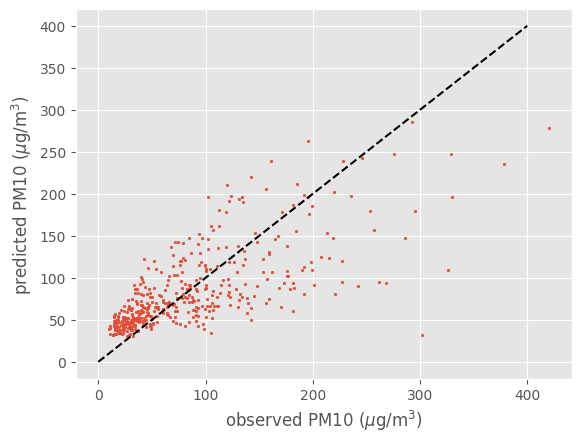

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9b9a5ec320>

In [36]:
figure()
xlabel(L"observed PM10 ($\mu$g/m$^3$)")
ylabel(L"predicted PM10 ($\mu$g/m$^3$)")
scatter(y_test, y_pred, s=3)
plot([0, 400], [0, 400], color="k", linestyle="--")

In [37]:
rmse = sqrt(sum((y_pred - y_test) .^ 2) / length(y_test))

47.57449854232524

#### assess underlying assumptions of linear regression and plot residuals vs. dependent variable

see [residuals plot](https://www.scikit-yb.org/en/latest/api/regressor/residuals.html)

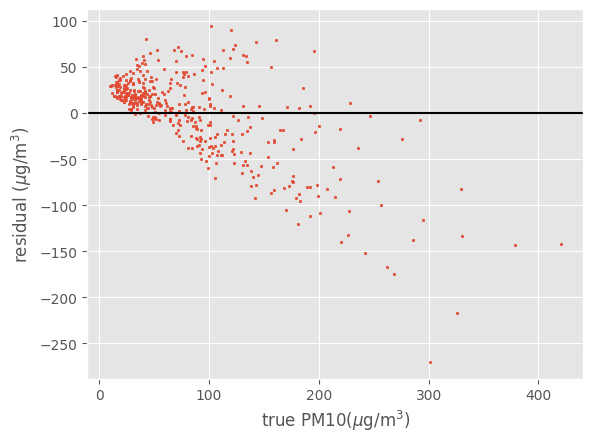

PyObject <matplotlib.lines.Line2D object at 0x7f9b9a4b2c18>

In [38]:
residuals = y_pred .- y_test

figure()
xlabel(L"true PM10($\mu$g/m$^3$)")
ylabel(L"residual ($\mu$g/m$^3$)")
scatter(y_test, residuals, s=3)
axhline(y=0.0, color="k")

at low (high) PM10 concentrations, the residuals appear to be biased above (below) zero. thus, a non-linear model may have lower mean square error on the test data if trained properly to avoid overfitting. it appears that the variance is much larger at higher PM10 concentrations.

## aside: when 2D histograms are better than 2D scatter plots

in a scatter plot, the points are sometimes buried and it is difficult to assess the density.

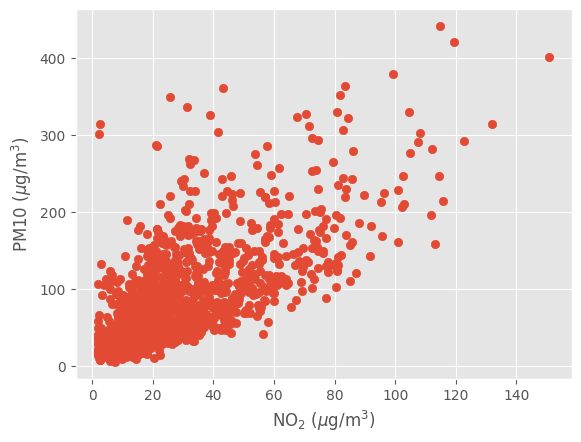

PyObject Text(34.10000000000001, 0.5, 'PM10 ($\\mu$g/m$^3$)')

In [50]:
figure()
scatter(df_by_day[:, :avg_NO2], df_by_day[:, :avg_PM10])
xlabel(L"NO$_2$ ($\mu$g/m$^3$)")
ylabel(L"PM10 ($\mu$g/m$^3$)")

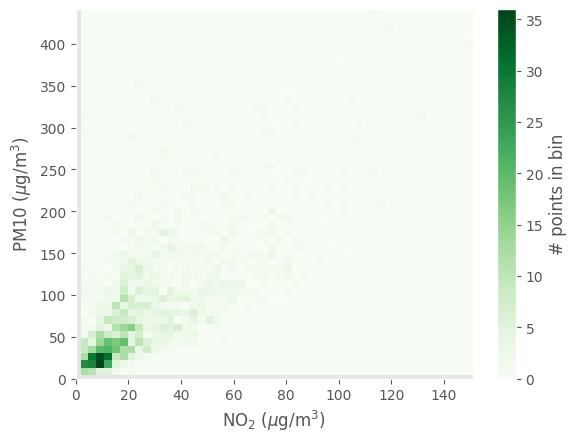

PyObject <matplotlib.colorbar.Colorbar object at 0x7f9b99e71ef0>

In [54]:
hist2D(df_by_day[:, :avg_NO2], df_by_day[:, :avg_PM10], cmap="Greens", bins=50)
xlabel(L"NO$_2$ ($\mu$g/m$^3$)")
ylabel(L"PM10 ($\mu$g/m$^3$)")
xlim(xmin=0.0)
ylim(ymin=0.0)
colorbar(label="# points in bin")